In [11]:
# adapted from https://www.tensorflow.org/tutorials/generative/autoencoder

import tensorflow as tf
from tensorflow.keras import losses, datasets, Model
from load_oxford_flowers102 import load_oxford_flowers102
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Flatten, Concatenate
import gzip
import pickle

# Load Oxford Flowers dataset
train_data, validation_data, test_data, class_names = load_oxford_flowers102(imsize=96, fine=True)

x_train = train_data["images"]
x_test = test_data["images"]
x_valid = validation_data["images"]

# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_valid = x_valid.astype('float32') / 255.

load_from_file = True

# Define U-Net like model

In [2]:
# adapted from https://medium.com/geekculture/u-net-implementation-from-scratch-using-tensorflow-b4342266e406

def encode_block(inputs, n_filters):
    conv = Conv2D(n_filters, kernel_size=(3,3), activation='relu', padding='same')(inputs)
    conv = Conv2D(n_filters, kernel_size=(3,3), activation='relu', padding='same')(conv)
    out = MaxPooling2D(strides=(2,2))(conv)
    skip = conv
    return out, skip

def decode_block(inputs, skip, n_filters):
    upconv = Conv2DTranspose(n_filters, kernel_size=(3,3), strides=(2,2), padding='same')(inputs)
    concat = Concatenate()([upconv, skip])
    conv = Conv2D(n_filters, kernel_size=(3,3), activation='relu', padding='same')(concat)
    out = Conv2D(n_filters, kernel_size=(3,3), activation='relu', padding='same')(conv)
    return out

def bottleneck(inputs, n_filters):
    conv = Conv2D(n_filters, kernel_size=(3,3), activation='relu', padding='same')(inputs)
    conv = Conv2D(n_filters, kernel_size=(3,3), activation='relu', padding='same')(conv)
    return conv

def create_unet(input_shape, n_filters=32):
    inputs = Input(input_shape)

    encode1, skip1 = encode_block(inputs, n_filters=32)
    encode2, skip2 = encode_block(encode1, n_filters=64)
    encode3, skip3 = encode_block(encode2, n_filters=128)
    # encode4, skip4 = encode_block(encode3, n_filters=256)

    latent_dim = bottleneck(encode3, n_filters=512)

    # decode1 = decode_block(latent_dim, skip4, n_filters=256)
    decode2 = decode_block(latent_dim, skip3, n_filters=128)
    decode3 = decode_block(decode2, skip2, n_filters=64)
    decode4 = decode_block(decode3, skip1, n_filters=32)

    out = Conv2D(3, kernel_size=(1,1), padding='same')(decode4)

    model = tf.keras.Model(inputs=inputs, outputs=out)
    return model        

unet = create_unet(x_train[0].shape, n_filters=32)
unet.summary()

2024-04-15 19:34:17.155847: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-15 19:34:17.175581: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-15 19:34:17.175668: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 96, 96,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 96, 96,    │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 48, 48,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 48, 48,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 48, 48,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 24, 24,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 24, 24,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 24, 24,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 12, 12,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 12, 12,    │    590,336 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 12, 12,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 24, 24,    │    589,952 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 24, 24,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 24, 24,    │    295,040 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 24, 24,    │    147,584 │ conv2d_8[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 48, 48,    │     73,792 │ conv2d_9[0][0]  

 Total params: 4,500,515 (17.17 MB)

 Trainable params: 4,500,515 (17.17 MB)

 Non-trainable params: 0 (0.00 B)

# Generate Noisy Dataset

In [3]:
def incremental_noise(images, noise_factor_increment=0.25, n_increments=20):
    noisy_images = []
    noisy_labels = []

    for image in images:
        for _ in range(n_increments):
            noisy_labels.append(image) # relatively clean image

            image = image + noise_factor_increment * tf.random.normal(shape=image.shape) 

            image = tf.clip_by_value(image, clip_value_min=0., clip_value_max=1.)

            noisy_images.append(image) # noisier image

    noisy_images = np.array(noisy_images)
    noisy_labels = np.array(noisy_labels)
    return noisy_images, noisy_labels 

In [4]:
n_increments = 20
dataset_size = 10000 #len(x_train)*2
noise_factor_increment=0.2
n_images = (int)(dataset_size/n_increments)
print(dataset_size)
print(noise_factor_increment)

10000
0.2


In [5]:
x_train_noisy, y_train_noisy = incremental_noise(x_train[:n_images], noise_factor_increment=noise_factor_increment, n_increments=n_increments)
x_valid_noisy, y_valid_noisy = incremental_noise(x_valid[:n_images], noise_factor_increment=noise_factor_increment, n_increments=n_increments)

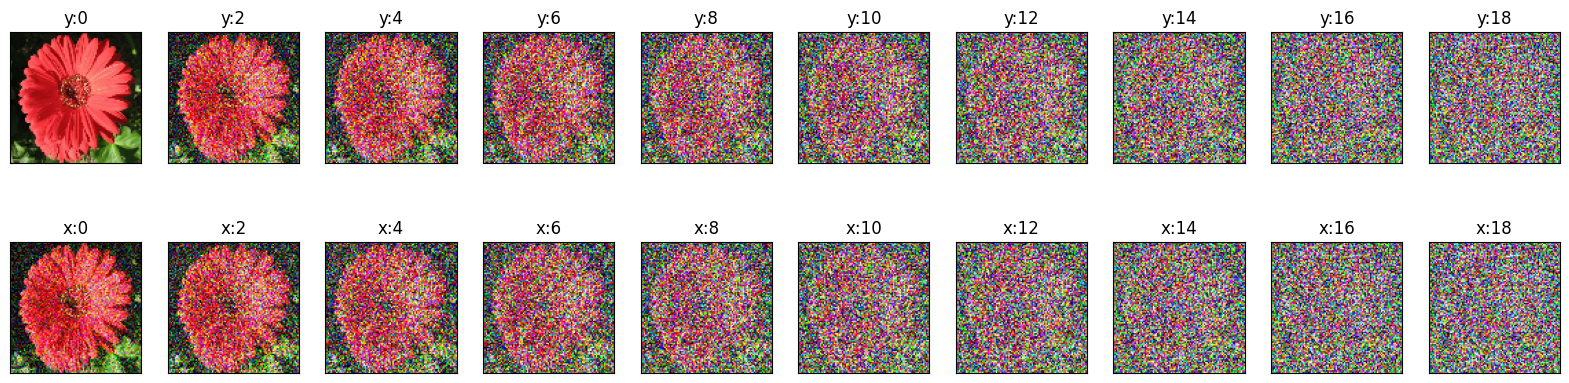

In [6]:
n = (int)(n_increments/2)
plt.figure(figsize=(20, 5))
for i in range(n):

    ax = plt.subplot(2, n, i + 1)
    plt.title(f'y:{i*2}')
    plt.imshow(tf.squeeze(y_train_noisy[i*2]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bx = plt.subplot(2, n, i + n + 1)
    plt.title(f'x:{i*2}')
    plt.imshow(tf.squeeze(x_train_noisy[i*2]))
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

plt.show()

# Train as Generative Model

In [7]:
unet = create_unet(x_train[0].shape, n_filters=32)
unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
             loss=tf.keras.losses.MeanSquaredError())


In [12]:
if load_from_file:
    unet.load_weights('saved/generative_unet.h5')
else:
    train_info = unet.fit(x_train_noisy, y_train_noisy,
                epochs=10,
                batch_size=n_increments,
                validation_data=(x_valid_noisy, y_valid_noisy))
    history=train_info.history
    unet.save('saved/generative_unet2.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


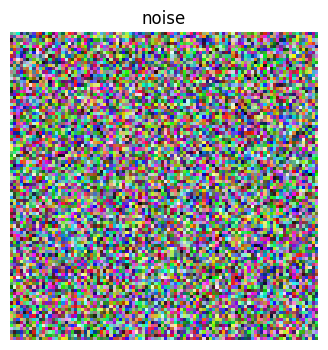

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


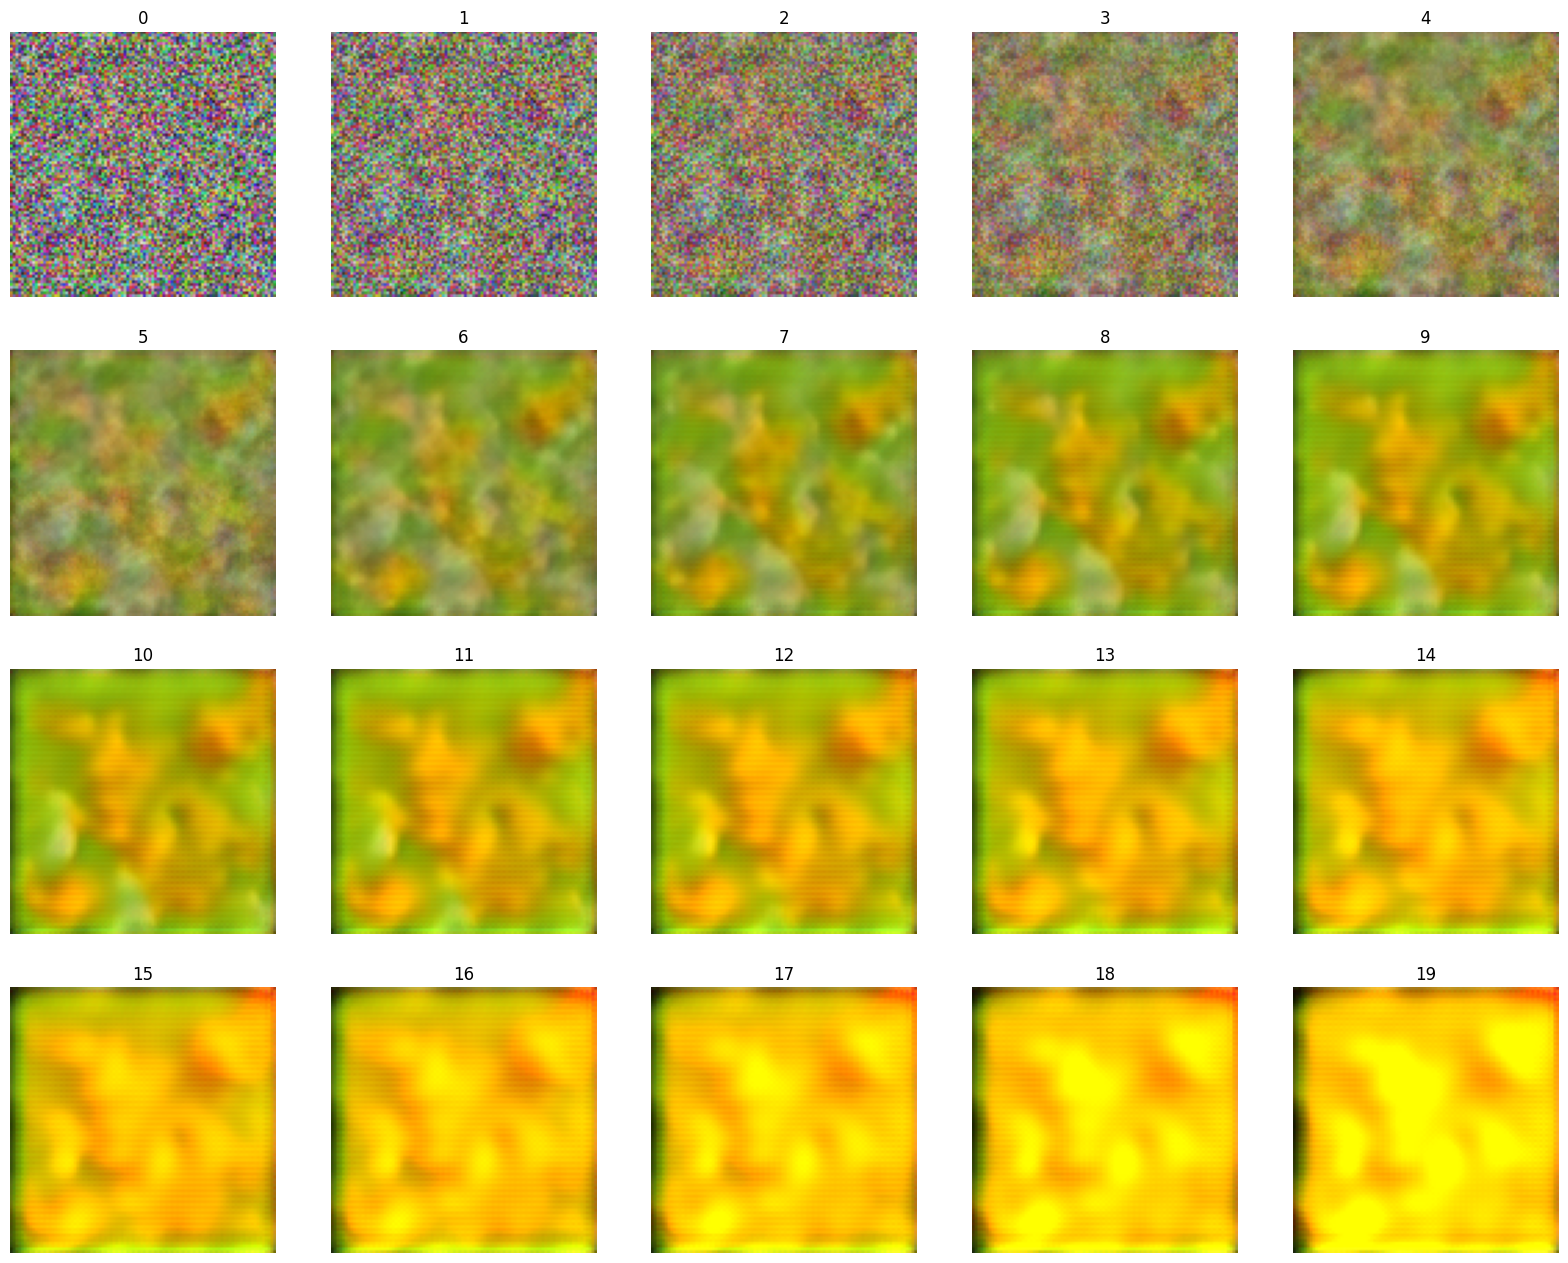

In [13]:
n_images = 1
n_iterations = n_increments
base_images = tf.ones((n_images, 96, 96, 3)) * 0
noise_images = base_images + tf.random.uniform((n_images, 96, 96, 3))

noise_images = tf.clip_by_value(noise_images, clip_value_min=0.0, clip_value_max=1)
generated_flowers = unet.predict(noise_images)

n_cols = 5
n_rows = (n_iterations + 1) // n_cols + ((n_iterations + 1) % n_cols != 0)


plt.figure(figsize=(4, 4))
plt.title('noise')
plt.imshow(tf.squeeze(noise_images[0]))
plt.axis('off')
plt.show()

plt.figure(figsize=(20, 4 * n_rows))
for i in range(n_iterations):
    generated_flowers = unet.predict(generated_flowers[:1])
    plt.subplot(n_rows, n_cols, i+1)
    plt.title(f'{i}')
    plt.imshow(tf.squeeze(generated_flowers[0]))
    plt.axis('off')
plt.show()


In [10]:
#Plot training and validation accuracy over the course of training
if not load_from_file:
    fh = plt.figure()
    ph = fh.add_subplot(111)
    ph.plot(history['loss'], label='loss')
    ph.plot(history['val_loss'], label = 'val_loss')
    ph.set_xlabel('Epoch')
    ph.set_ylabel('Loss')
    ph.legend(loc='upper right')
    plt.show()

NameError: name 'train_history' is not defined